# Q3

In [59]:
def mean_squared_error(R, U, V):
    prediction = U @ V.T
    error = np.sum((R[np.nonzero(R)] - prediction[np.nonzero(R)]) ** 2)
    return error / len(R[np.nonzero(R)])

def mean_absolute_error(R, U, V):
    prediction = U @ V.T
    abs_error = np.abs(R[np.nonzero(R)] - prediction[np.nonzero(R)])
    return np.mean(abs_error)

In [96]:
def train_latent_factor_model(R, d=1, lambda_reg=0.1, tol=1e-3):
    n_users, n_movies = R.shape
    U = np.random.rand(n_users, d)
    V = np.random.rand(n_movies, d)
    prev_loss = np.inf

    while True:
        U_prev = U.copy()
        V_prev = V.copy()

        # Update U
        for i in range(n_users):
            non_zero_indices = np.nonzero(R[i])[0]
            if len(non_zero_indices) > 0:
                Vj = V[non_zero_indices, :]
                Ri = R[i, non_zero_indices].reshape(-1, 1)
                U[i, :] = np.linalg.solve(Vj.T @ Vj + lambda_reg * np.eye(d), Vj.T @ Ri).flatten()

        # Update V
        for j in range(n_movies):
            non_zero_indices = np.nonzero(R[:, j])[0]
            if len(non_zero_indices) > 0:
                Ui = U[non_zero_indices, :]
                Rj = R[non_zero_indices, j].reshape(-1, 1)
                V[j, :] = np.linalg.solve(Ui.T @ Ui + lambda_reg * np.eye(d), Ui.T @ Rj).flatten()

        # Check for convergence
        delta_U = np.linalg.norm(U - U_prev, 'fro')
        delta_V = np.linalg.norm(V - V_prev, 'fro')
        current_loss = delta_U + delta_V

        if abs(prev_loss - current_loss) < tol:
            break
        prev_loss = current_loss

    return U, V

# Run the training for different values of d and lambda_reg
d_values = [1, 5, 20, 50]
lambda_reg_values = [1, 2, 4, 6]
results = []

for d in tqdm(d_values):
    for lambda_reg in lambda_reg_values:
        U_train, V_train = train_latent_factor_model(train_matrix, d=d, lambda_reg=lambda_reg)
        train_mse = mean_squared_error(train_matrix, U_train, V_train)
        train_mae = mean_absolute_error(train_matrix, U_train, V_train)
        test_mse = mean_squared_error(test_matrix, U_train, V_train)
        test_mae = mean_absolute_error(test_matrix, U_train, V_train)
        
        results.append({
            "d": d,
            "lambda_reg": lambda_reg,
            "train_mse": train_mse,
            "train_mae": train_mae,
            "test_mse": test_mse,
            "test_mae": test_mae
        })

# Output to a JSON file
output_path = './data/q3.json'
with open(output_path, "w") as outfile:
    json.dump(results, outfile, indent=2)

output_path

100%|██████████| 4/4 [06:18<00:00, 94.74s/it] 


'./data/q3.json'

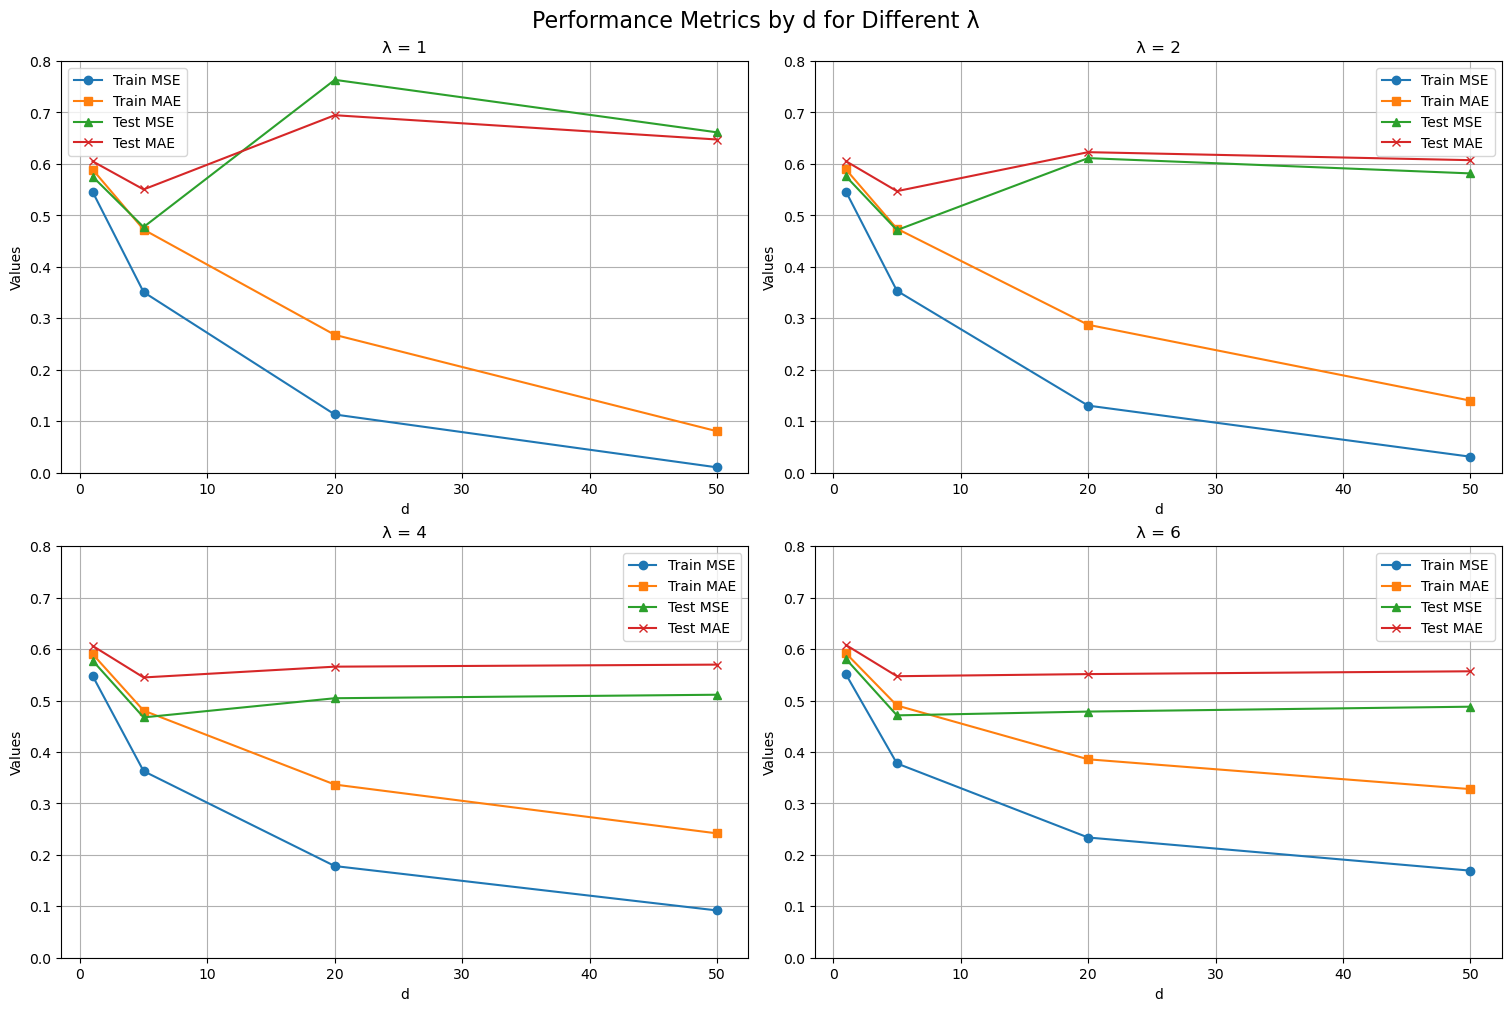

In [97]:

with open('./data/q3.json', 'r') as file:
    data = json.load(file)

# Extracting unique values of d and lambda_reg
ds = sorted(set(item['d'] for item in data))
lambda_regs = sorted(set(item['lambda_reg'] for item in data))

# Preparing plot data
plot_data = {lr: {'train_mse': [], 'train_mae': [], 'test_mse': [], 'test_mae': []} for lr in lambda_regs}

for lambda_reg in lambda_regs:
    for d in ds:
        filtered_data = [item for item in data if item['d'] == d and item['lambda_reg'] == lambda_reg]
        if filtered_data:
            for metric in ['train_mse', 'train_mae', 'test_mse', 'test_mae']:
                plot_data[lambda_reg][metric].append(filtered_data[0][metric])
        else:
            for metric in ['train_mse', 'train_mae', 'test_mse', 'test_mae']:
                plot_data[lambda_reg][metric].append(None)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)
fig.suptitle('Performance Metrics by d for Different λ', fontsize=16)

for ax, (lambda_reg, metrics) in zip(axs.flat, plot_data.items()):
    ax.plot(ds, metrics['train_mse'], marker='o', label='Train MSE')
    ax.plot(ds, metrics['train_mae'], marker='s', label='Train MAE')
    ax.plot(ds, metrics['test_mse'], marker='^', label='Test MSE')
    ax.plot(ds, metrics['test_mae'], marker='x', label='Test MAE')
    
    ax.set(title=f'λ = {lambda_reg}', xlabel='d', ylabel='Values')
    ax.set_ylim(0, 0.8)
    ax.legend()
    ax.grid(True)

plt.savefig('./ALS_Performance_Plot.png')
plt.show()

This is the plot of error metrics on the train and test as a function of d = [1, 2, 5, 10, 20, 50] with different λ = [1, 2, 4, 6].
We can see that as λ grow from 1 to 4, the testing performance is increases, this is benefit from the advantage of regularization that reduce the over-fitting when learning the training set. But if the regularization is too strong (as λ growing from 4 to 6) the testing performance doesn't change much but lower the training performance. Thus, we choose λ=4 to achieve a balance between fitting the training data and generalizing to test data.

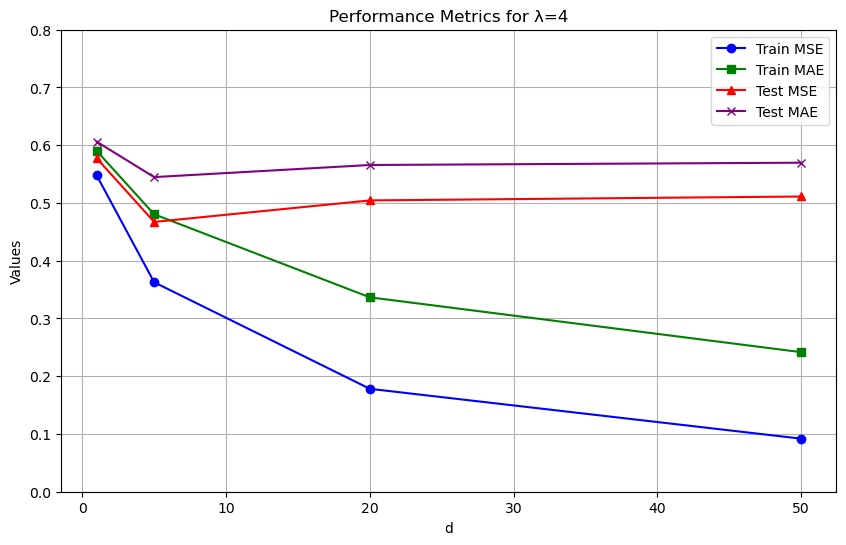

In [98]:
with open('./data/q3.json', 'r') as file:
    data = json.load(file)

# Assuming the lambda_reg values are sorted, pick the third one
lambda_regs = sorted(set(item['lambda_reg'] for item in data))
selected_lambda_reg = lambda_regs[2]  # This selects the third unique lambda_reg value

# Filtering data for the selected lambda_reg
filtered_data = [item for item in data if item['lambda_reg'] == selected_lambda_reg]
# Sorting the filtered data by 'd' to ensure correct plotting order
filtered_data = sorted(filtered_data, key=lambda x: x['d'])

# Extracting values for plotting
ds = [item['d'] for item in filtered_data]
train_mse = [item['train_mse'] for item in filtered_data]
train_mae = [item['train_mae'] for item in filtered_data]
test_mse = [item['test_mse'] for item in filtered_data]
test_mae = [item['test_mae'] for item in filtered_data]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ds, train_mse, marker='o', color='blue', label='Train MSE')
plt.plot(ds, train_mae, marker='s', color='green', label='Train MAE')
plt.plot(ds, test_mse, marker='^', color='red', label='Test MSE')
plt.plot(ds, test_mae, marker='x', color='purple', label='Test MAE')

plt.title(f'Performance Metrics for λ={selected_lambda_reg}')
plt.xlabel('d')
plt.ylabel('Values')
plt.ylim(0, 0.8)
plt.legend()
plt.grid(True)
plt.show()

The final metrics plot of different d values